# AIF_sprint2-linear-reg

## 今回の目標

- 線形回帰を通して、基本的な機械学習のアルゴリズムを学ぶ
- スクラッチを通して、コーディング力を向上させる
- スクラッチを通して、アルゴリズムを理解する。
- 基本的な機械学習のキーワードを学習する。

## 機械学習とは

機械学習とはデータをある規則に従って学習を行い、新たなデータが来たときに何らかの予測を行ったり、データ間の関係を導くものです。

機械学習には大きく分けて４種類あります。

1. 教師あり学習
    - 学習時に予測して欲しい出力データも一緒に学習させる。答え（予測するもの）によって回帰と分類に分けられます。
        1. 回帰
            - 連続値を予測する　
                - 例 家のデータから販売価格の予測、過去データから株価予測
        1. 分類
            - 離散値（カテゴリー）を分類する
                - 例　身体データからガンかどうかを分類、硬貨データから（1円から500円）を判別する
1. 教師なし学習
    - 学習時に答えとなるデータがない学習。データ間の隠れたパターンや構造を見つける。
        - 例 購買情報から次の商品開発のためのターゲットを決める。
1. 半教師あり学習
    - 学習時に答えとなるデータも一緒に学習させるためのデータを用意するのは非常にコストが掛かる。たとえば数千万枚の画像にその画像にタグ（名前）をつけるのは現実的ではないのでクラスタリングを行って、そのクラスターに対してラベルを与えることで　少量の教師ありデータで学習で分類器を作って教師なしのデータに対しても分類ができるようにする。
        - 例1　google photoで家族写真を何枚も保存してまず人物をクラスタリングする。そして人物ごとにラベルを与えることで今後写真の人物を判別できる。
        - 例2 GAN　少数の教師データとgeneratorが作った偽物を識別するように学習することで精度をあげることができる
        
1. 強化学習
    - エージェントと呼ばれる行動する主体（ロボットやゲームAIの思考部）が行動を行い、その結果をエージェントにフィードバックして次の行動を決定する。
        - ロボットの関節制御、ゲームAI（Atari、alphaGo)
> [参考1](http://blog.brainpad.co.jp/entry/2017/02/24/121500)
>
> [参考2](https://deepage.net/machine_learning/2017/08/10/reinforcement-learning.html#atari%E3%81%AE%E6%94%BB%E7%95%A5)

今回はhouse-priceコンペのデータを用いて教師あり学習の回帰問題に取り組みます。
家データ（１階のリビング面積、築年数）から販売価格を自分で実装した最急降下法で予測します。

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## データ・セットの用意

In [2]:
data = pd.read_csv('../input/train.csv')

今回目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使用する。
データを目的変数と説明変数に分ける。

In [3]:
x_df = data[['GrLivArea', 'YearBuilt']]
y_df = data[['SalePrice']]

In [4]:
x_df.head()

,GrLivArea,YearBuilt
0,1710,2003
1,1262,1976
2,1786,2001
3,1717,1915
4,2198,2000


In [5]:
y_df.head()

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


データ読み込みが完了しました。
次にデータをプロットしてみます。
## プロット

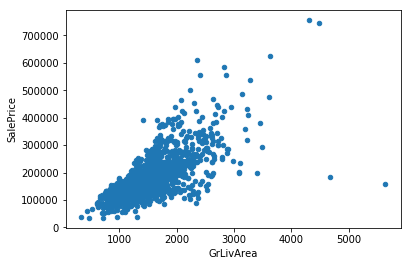

In [6]:
# grlivareaとsalepriceの関係を散布図にする
# 項目を横並びにならべる。 axis=0だと縦に並べる
scatter_df = pd.concat([y_df['SalePrice'], x_df['GrLivArea']], axis=1)
# yの範囲を0,800000にして散布図を表示
scatter_df.plot.scatter(x='GrLivArea', y='SalePrice');

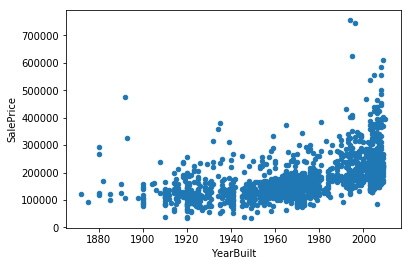

In [8]:
# salepriceとYearBuiltの関係を散布図にする
# 項目を横並びにならべる。 axis=0だと縦に並べる
scatter_df = pd.concat([x_df['YearBuilt'], y_df['SalePrice']], axis=1)
# yの範囲を0,800000にして散布図を表示
scatter_df.plot.scatter(x='YearBuilt', y='SalePrice');

目的変数と説明変数間には正の相関があることが分かります。

## フィーチャースケーリング

複数の変数を同じスケールに変形すること。変形方法は２つあります。

###  正規化

値を０から１の範囲に収まるように変形すること。

$ x_{normalization} = \frac{x - min}{max -min}$

### 標準化

値を平均０、標準偏差１に変形すること。

$ x_{standardization} = \frac{x - mean}{std} $

### 正規化と標準化の使い分け
- 正規化
    - ｘの分布が一様分布と想定する場合（外れ値の影響をうけやすいため）
- 標準化
    - xの分布がガウス分布と想定する場合　

フィーチャースケーリングすることで各特徴量のスケールを同じ範囲に設定することで
$\theta$の更新スピードが同じくらいになるため
より少ない学習回数で収束することができる。

逆に正規化を行わないとある変数は収束しているが、別の変数がなかなか収束しないことが発生収束スピードが遅くなる。

In [9]:
# 正規化
x_norm = (x_df - x_df.mean())/ x_df.std()
y_norm = (y_df - y_df.mean())/ y_df.std()

## 数式の実装

線形回帰における、目的関数（コスト関数）を実装する。

$h_\theta(x) = \theta_0x_0 + \theta_1x_1 +\cdots + \theta_nx_n(x_0=1)$

$J(\theta) = \frac{1}{2m} \displaystyle\sum_{i=1}^m (h_\theta(x^{(i)}-y^{(i)})^2$

In [12]:
def compute_cost(X, y, theta):
    # TODO: implemet try: except statement
    
    # data size
    m = y.count()
    # add x0's row
    X['x0'] = 1 
    error = np.dot(X, theta) - np.array(y)
    return  (error ** 2).sum() / (2 * m)

## $\theta_0$の役割

線形回帰モデルは、以下のように 
$\theta_0$
 つまり、切片が存在する。

$h_\theta(x) = \theta_0x_0 + \theta_1x_1 +\cdots + \theta_nx_n(x_0=1)$

この$\theta_0$
 は、線形回帰モデルにおいてどのように役立っているか述べよ。

### 回答

今回の場合でいうと築年数が０年（新築）のとき切片がないと販売価格が0円になってしまいます。
つまり、説明変数の値が0のときの値を正しく表現するために切片が必要となります。
 


## 最急降下法(勾配降下法、GradientDescent)

最急降下法を実装すること。また、内部からコスト関数を呼び出し、アルゴリズムを完成させること。
数式は以下になる。

$\theta_j := \theta_j - \alpha \frac{1}{m} \displaystyle\sum_{i=1}^m[(h_\theta(x^{(i)}-y^{(i)})x_j^{(i)} ]$ 

In [13]:
def gradient_descent(X, y, theta, iterations, alpha):
    """
    args:
      alpha: Step size/Learning rate
      iterations: No. of iterations(Number of iterations)
    """
    # data size
    m = int(y.count())
    
    # add x0's row
    X['x0'] = 1
    
    # need initial 
    past_costs = [compute_cost(X, y, theta)]
    past_thetas = [theta]
    
    for i in range(iterations):
        # update theta parameter
        error = np.dot(X, theta) - np.array(y)
        theta = theta - alpha/m * np.dot(X.T, error)
        cost = compute_cost(X, y, theta)
        # print("{} iteration's cost is {}".format(i, cost))
        # store now cost and theta
        past_costs.append(cost)
        past_thetas.append(theta)
    return (past_costs, past_thetas)

関数を実装するときは、更新される前の、thetaとcostを保持する変数past_costsとpast_thetasに順次過去の値をappendする必要がある。

## 線形回帰に最急降下法の導出式を記述せよ

以下の式から、
$\theta_j := \theta_j - \frac{\partial}{\partial \theta_j}J(\theta) $　 





この式が得られるまでを導出すれば良い
$\theta_j := \theta_j - \alpha \frac{1}{m} \displaystyle\sum_{i=1}^m[(h_\theta(x^{(i)}-y^{(i)})x_j^{(i)} ]$ 

但し、 
$i\neq0$
 である。
 
上の２式を比べると、
$ \frac{\partial}{\partial \theta_j}J(\theta) = \alpha \frac{1}{m} \displaystyle\sum_{i=1}^m[(h_\theta(x^{(i)}-y^{(i)})x_j^{(i)} ]$ となればよい。

$  \frac{\partial}{\partial \theta_j}J(\theta) = \frac{\partial}{\partial \theta_j}\frac{\alpha}{2m}\displaystyle\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2$ を合成関数の微分とみなす。



これに$g(u)= u^2 ,u= h_\theta(x^{(i)}) - y^{(i)}$としてそれぞれ$u, \theta_j$で微分する。

$\frac{\partial g(u) }{\partial u} = 2u$

$\frac{\partial u}{\partial \theta_j} = x_j^{(i)}$

となる。これを代入して、

$\frac{\partial}{\partial \theta_j}J(\theta) = \frac{\partial}{\partial \theta_j}\frac{\alpha}{2m}\displaystyle\sum_{i=1}^m \frac{\partial g(u)}{\partial u}  \frac{\partial u}{\partial \theta_j}$

$= \frac{\partial}{\partial \theta_j}\frac{\alpha}{2m}\displaystyle\sum_{i=1}^m 2u x_j^{(i)}$

$= \frac{\partial}{\partial \theta_j}\frac{\alpha}{m}\displaystyle\sum_{i=1}^m u x_j^{(i)}$

$= \frac{\alpha}{m} \displaystyle\sum_{i=1}^m[(h_\theta(x^{(i)}-y^{(i)})x_j^{(i)} ]$

となるため






## 最急降下法について、なぜ局所最適解が得られる場合があるか答えよ

但し、線形回帰の場合は局所最適解ではなく、最適解が得られる。この理由も述べよ。

下記の場合は0付近の値からスタートするとコストが０に収束してしまうが、実際には5か-5の値が最小値が存在する。
このため最急勾配法では初期値によって局所解に陥る可能性がある。

線形回帰の場合は今回の場合は二乗誤差関数のため各$\theta$が２乗関数のため必ず最小値が１つのため最適解が求められる。


Text(0.5,1,'local optimum')

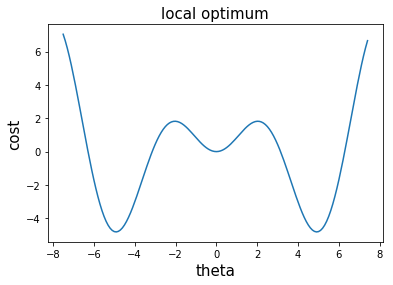

In [90]:
x = np.arange(-7.5, 7.5, 0.1)
y = np.sin(x)*x 
plt.plot(x, y)
plt.xlabel('theta', fontsize=15);
plt.ylabel('cost', fontsize=15);
plt.title('local optimum', fontsize=15)


## 学習

### 学習率

学習曲線が収束したとしてもそのサンプルにだけに適応している可能性がある。

この状態をOverfittingと呼ぶ。

またうまく収束しなかった場合はunderfittingといい学習不足状態となり、サンプルにも母集団にもフィットしない。

学習率は非常に小さい値だと収束までに時間がかかるが、逆に大きすぎるとうまく収束しなかったり、発散してしまう。

学習率は0.01から0.1など小さい値からはじめ学習曲線を見て徐々に大きい値を採用するのがよい。

### 学習曲線について述べよ

学習曲線はコストを最適化するような問題に対して学習をステップで実行するような学習方法を使うさいに使われます。

学習曲線は学習回数とコストのプロットした結果になります。

これでその学習率で収束したかどうか、収束速度がひと目で分かるため学習率のチューニングに使用されます。


### 学習曲線のプロット

past_costsを使用して、学習曲線を表示する関数を作成せよ。

In [14]:
# theta は必要？
def plot_learning_curve(X, y, iterations, alpha): 
    # parameter size
    theta_size = X.shape[1]
    
    # set initial theta
    theta = pd.DataFrame(np.random.rand(theta_size))
    
    past_costs = gradient_descent(X, y, theta, iterations, alpha)[0]
    plt.plot(np.array(list(range(iterations+1))), np.array(past_costs))
    
    plt.title('Learning Curve', fontsize=20)
    
    plt.xlabel("iteration", fontsize=15)
    plt.ylabel("cost", fontsize=15)
    print("last cost is {}".format(past_costs[-1]))

下記のようにコストが下がって収束しているのが分かる。

last cost is SalePrice    0.173246
dtype: float64


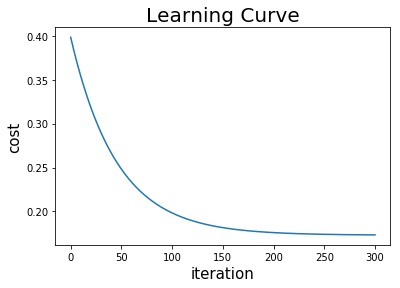

In [71]:
plot_learning_curve(x_norm, y_norm, 300, 0.01);

last cost is SalePrice    0.172886
dtype: float64


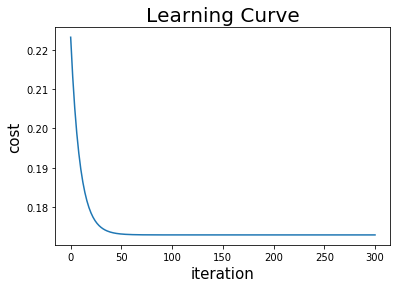

In [72]:
plot_learning_curve(x_norm, y_norm, 300, 0.05);

last cost is SalePrice    0.339965
dtype: float64


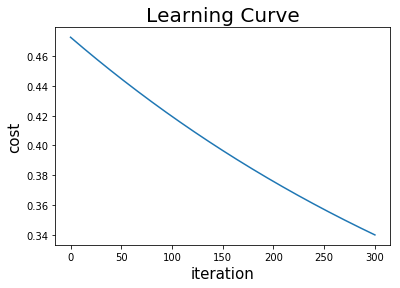

In [73]:
plot_learning_curve(x_norm, y_norm, 300, 0.001);

## クラス化

In [27]:
class LinearModel():

    def __init__(self):
        pass

    def compute_cost(self, X, y, theta):
        # TODO: implemet try: except statement
        # data size
        m = y.count()
        # add x0's row
        #X['x0'] = 1 
        error = np.dot(X, theta) - np.array(y)
        return  (error ** 2).sum() / (2 * m)

    def gradient_descent(self, X, y, theta, iterations, alpha):
        """
        args:
          alpha: Step size/Learning rate
          iterations: No. of iterations(Number of iterations)
        """
        # data size
        m = int(y.count())

        # add x0's row
        X['x0'] = 1

        # need initial 
        past_costs = [compute_cost(X, y, theta)]
        past_thetas = [theta]

        for i in range(iterations):
            # update theta parameter
            error = np.dot(X, theta) - np.array(y)
            theta = theta - alpha/m * np.dot(X.T, error)
            cost = compute_cost(X, y, theta)
            # print("{} iteration's cost is {}".format(i, cost))
            # store now cost and theta
            past_costs.append(cost)
            past_thetas.append(theta)
        return (past_costs, past_thetas)

    def plot_learning_curve(self, X, y, iterations, alpha): 
        # parameter size
        # theta_size = X.shape[1]

        # set initial theta
        theta = pd.DataFrame(np.random.rand(X.shape[1]))

        past_costs = gradient_descent(X, y, theta, iterations, alpha)[0]
        plt.plot(np.array(list(range(iterations+1))), np.array(past_costs))

        plt.title('Learning Curve', fontsize=20)

        plt.xlabel("iteration", fontsize=15)
        plt.ylabel("cost", fontsize=15)
        print("last cost is {}".format(past_costs[-1]))

last cost is SalePrice    0.172886
dtype: float64


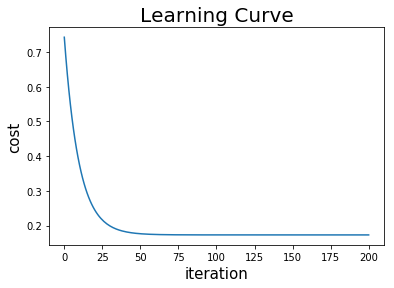

In [28]:
gmodel = LinearModel()
gmodel.plot_learning_curve(x_norm, y_norm, 200, 0.05)

In [102]:
gmodel.compute_cost(x_norm, y_norm, np.random.rand(3))

SalePrice    1830.833574
dtype: float64

In [46]:
theta = pd.DataFrame(np.random.rand(x_norm.shape[1]))
cost_history, thetas_history = gmodel.gradient_descent(x_norm, y_norm, theta, 10, 0.1)

In [54]:
for i, cost in enumerate(cost_history):
    print("{} iteration's cost : {} ".format(i, float(cost)))

0 iteration's cost : 0.4505587598944206 
1 iteration's cost : 0.39919039344244767 
2 iteration's cost : 0.3574963799468602 
3 iteration's cost : 0.32362294296492455 
4 iteration's cost : 0.29607741897416656 
5 iteration's cost : 0.2736568167017192 
6 iteration's cost : 0.2553907143756428 
7 iteration's cost : 0.24049557904370775 
8 iteration's cost : 0.22833819228782504 
9 iteration's cost : 0.21840634194865707 
10 iteration's cost : 0.21028531611290946 


クラス化でき、各関数が実行できることが確認できた。

## 正規方程式

最急勾配法とは異なったアプローチで$\theta$を求める正規方程式という方法がある。
メリット・デメリットは再急降下法と合わせてこのようになっている。

|  | 最急降下法 | 正規方程式 |
|:-----------|------------:|:------------:|
| メリット | 特徴量がスケールしても遅くなりづらい | 学習率のチューニングと繰り返しが不要|
| デメリット | 学習率のチューニングが必要 | 逆行列の計算があるため特徴量、データ数が増えると遅くなる |


## テスト

unittestに至らなかったため、シンプルに想定値と動作値を確認する。

In [115]:
x = pd.DataFrame([1, 2])
y = pd.DataFrame([2, 3])
theta = pd.DataFrame([0.5, 0.5])
expected = pd.Series(0.8125)
actual = compute_cost(x, y, theta)
np.testing.assert_almost_equal(float(expected), float(actual))

In [134]:
x = pd.DataFrame([1, 2])
y = pd.DataFrame([2, 3])
theta = pd.DataFrame([0.5, 0.5])
expected_cost = np.array(0.0)
expected_thetas = np.array([[1.0],[1.0]])

actual_costs, actual_thetas = gradient_descent(x, y, theta, 500, 0.01)
np.testing.assert_almost_equal(actual_costs[-1], expected_cost, decimal=1)
np.testing.assert_almost_equal(actual_thetas[-1], expected_thetas, decimal=1)

アラートがないため動作値が想定値に近似した値であることが確認できた。